In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVR

In [2]:
# Load the dataset
file_path = 'Total_Crops.csv'
data = pd.read_csv(file_path)

# Drop the arrivalquantity attribute
data = data.drop(columns=['arrivalquantity'])

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85260 entries, 0 to 85259
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   mandiid       85260 non-null  int64 
 1   cropid        85260 non-null  int64 
 2   cropname      85260 non-null  object
 3   mandiname     85260 non-null  object
 4   maximumprice  85260 non-null  int64 
 5   minimumprice  85260 non-null  int64 
 6   modalprice    85260 non-null  int64 
 7   date          85260 non-null  object
dtypes: int64(5), object(3)
memory usage: 5.2+ MB


In [4]:
data.head()

,mandiid,cropid,cropname,mandiname,maximumprice,minimumprice,modalprice,date
0,777,10,Paddy,Alibagh,2500,2000,2200,2021-08-03
1,234,7,Onion,SATANA,1800,750,1600,2021-08-03
2,778,1,Corn,Amalner,1700,1630,1700,2021-08-04
3,508,2,Cotton,Khambha,8625,3500,6425,2021-10-08
4,1212,1,Corn,Lakhimpur,1625,1590,1615,2021-10-08


In [5]:
# Convert the date column to datetime
data['date'] = pd.to_datetime(data['date'])

# Extract additional features from the date
data['year'] = data['date'].dt.year
data['month'] = data['date'].dt.month
data['day'] = data['date'].dt.day

In [6]:
# Create lag features
data = data.sort_values(by='date')
for lag in range(1, 22):  # Using past 21 days to predict the next day
    data[f'lag_modalprice_{lag}'] = data['modalprice'].shift(lag)

# Drop rows with missing values created by lag features
data = data.dropna()

In [7]:
# Encode categorical variables
label_encoder_mandi = LabelEncoder()
label_encoder_crop = LabelEncoder()
data['mandiid'] = label_encoder_mandi.fit_transform(data['mandiid'])
data['cropid'] = label_encoder_crop.fit_transform(data['cropid'])

In [8]:
# Define features and target
features = ['mandiid', 'cropid', 'year', 'month', 'day'] + \
           [f'lag_modalprice_{i}' for i in range(1, 22)]
target = 'modalprice'

X = data[features]
y = data[target]

# Standardize the features
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [9]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
# Train the model using SVM Regression
svm_model = SVR(kernel='linear', C=5, gamma=0.0001)  # Example parameters, adjust as needed
svm_model.fit(X_train, y_train)

SVR(C=5, gamma=0.0001, kernel='linear')

In [11]:
# Make predictions on the test set
y_pred = svm_model.predict(X_test)

In [12]:
# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error: {mae}')

Mean Absolute Error: 1201.3501784679781


In [13]:
# Ensure predictions are non-negative
y_pred = np.clip(y_pred, a_min=0, a_max=None)

In [14]:
# User interaction for input
cropid_input = int(input("Enter cropid: "))
mandiid_input = input("Enter mandiid (leave blank for all mandis): ")

Enter cropid:  1
Enter mandiid (leave blank for all mandis):  778


In [15]:
# Convert user inputs to encoded values
cropid_encoded = label_encoder_crop.transform([cropid_input])[0]

if mandiid_input:
    try:
        mandiid_encoded = label_encoder_mandi.transform([mandiid_input])[0]
        filtered_data = data[(data['cropid'] == cropid_encoded) & (data['mandiid'] == mandiid_encoded)]
        mandiname = data[data['mandiid'] == mandiid_encoded]['mandiname'].iloc[0]
    except IndexError:
        print(f"No data found for cropid {cropid_input} and mandiid {mandiid_input}.")
        exit()
else:
    filtered_data = data[data['cropid'] == cropid_encoded]
    mandiname = "All Mandis"

if filtered_data.empty:
    print(f"No data found for cropid {cropid_input} and mandiid {mandiid_input}.")
    exit()

In [16]:
# Get the number of days to predict
num_days_input = int(input("Enter the number of days to predict (5-15): "))
if num_days_input < 5 or num_days_input > 15:
    print("Please enter a valid number between 5 and 15 only.")
    num_days_input = int(input("Enter the number of days to predict (5-15): "))

Enter the number of days to predict (5-15):  10


In [17]:
# Predict future prices for the specified number of days
last_known = filtered_data[features].iloc[-1].values.reshape(1, -1)
future_predictions = []

for i in range(num_days_input):
    next_pred = svm_model.predict(last_known.reshape(1, -1))
    next_pred = np.clip(next_pred, a_min=0, a_max=None)
    future_predictions.append(next_pred[0])  # Append the first element of next_pred
    
    # Update the last_known array with the new prediction and shift the lags
    last_known = np.roll(last_known, -1)
    last_known[0, -1] = next_pred[0]  # Assign the first element of next_pred

    # Update lag features with new predictions
    for j in range(1, 21):
        last_known[0, features.index(f'lag_modalprice_{j}')] = last_known[0, features.index(f'lag_modalprice_{j+1}')] if j < 20 else next_pred[0]

In [18]:
# Create future dates
future_dates = pd.date_range(start=filtered_data['date'].max() + pd.Timedelta(days=1), periods=num_days_input, freq='D')
future_df = pd.DataFrame(future_predictions, columns=[target])
future_df['date'] = future_dates

# Get crop name from cropid
crop_name = data[data['cropid'] == cropid_encoded]['cropname'].iloc[0]

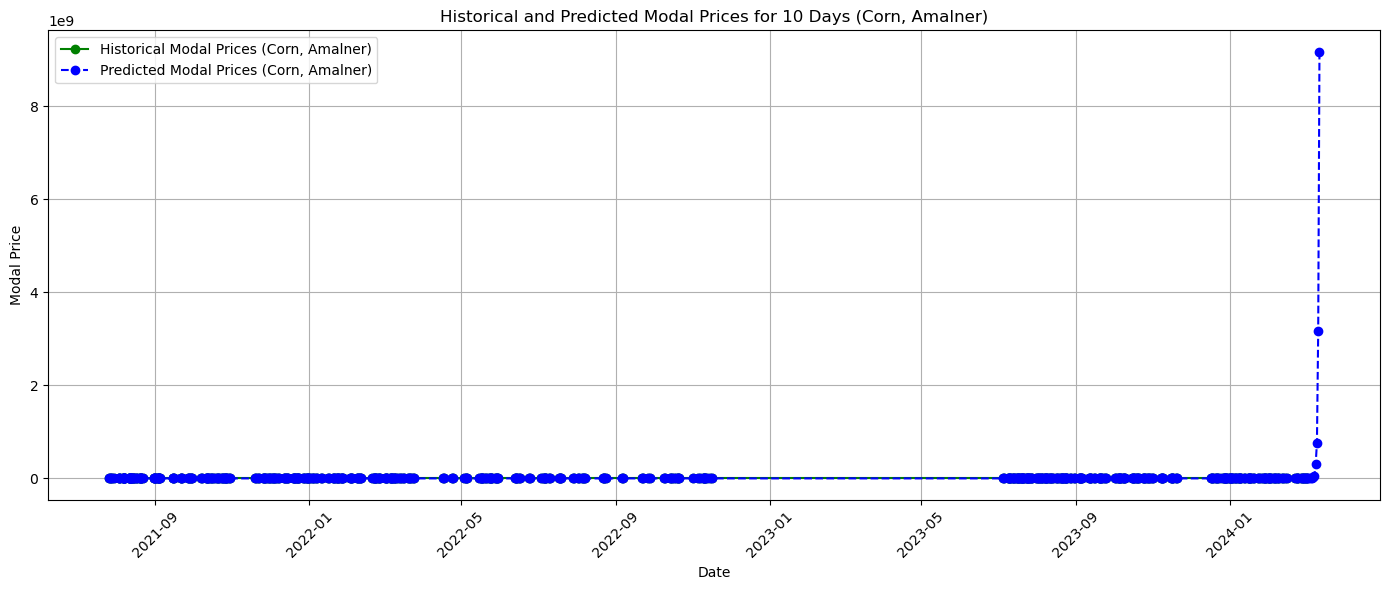

In [19]:
# Plot historical values and future predictions
plt.figure(figsize=(14, 6))
plt.plot(filtered_data['date'], filtered_data['modalprice'], marker='o', linestyle='-', color='g', label=f'Historical Modal Prices ({crop_name}, {mandiname})')

# Concatenate historical and future predictions
concat_dates = pd.concat([filtered_data['date'], future_df['date']])
concat_prices = pd.concat([filtered_data['modalprice'], future_df['modalprice']])

plt.plot(concat_dates, concat_prices, marker='o', linestyle='--', color='b', label=f'Predicted Modal Prices ({crop_name}, {mandiname})')

plt.title(f'Historical and Predicted Modal Prices for {num_days_input} Days ({crop_name}, {mandiname})')
plt.xlabel('Date')
plt.ylabel('Modal Price')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

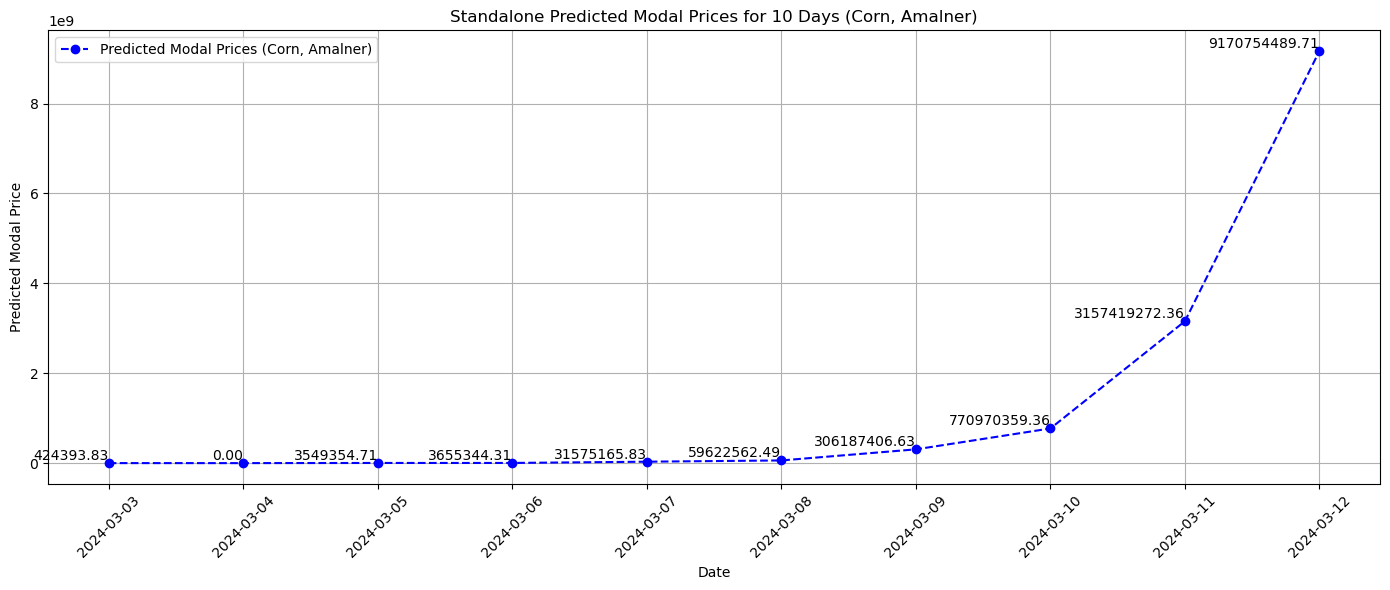

In [20]:
# Plot standalone future predictions for modal price with data labels
plt.figure(figsize=(14, 6))
plt.plot(future_df['date'], future_df['modalprice'], marker='o', linestyle='--', color='b', label=f'Predicted Modal Prices ({crop_name}, {mandiname})')

# Add data labels to each point in the standalone plot
for x, y in zip(future_df['date'], future_df['modalprice']):
    plt.text(x, y, f'{y:.2f}', ha='right', va='bottom', fontsize=10)

plt.title(f'Standalone Predicted Modal Prices for {num_days_input} Days ({crop_name}, {mandiname})')
plt.xlabel('Date')
plt.ylabel('Predicted Modal Price')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()
